In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load the dataset
train = pd.read_csv("../data/avis/train_noYC_lemma_sent_equil.csv", index_col=0)
y_train = train.etoiles
X_train = train.drop("etoiles", axis = 1)
X_train = X_train[['n_avis','sentiment_norm','longueur_texte']]
extra_features = X_train.columns.values

test = pd.read_csv('../data/avis/test_noYC_lemma_sent_equil.csv')
y_test = test['etoiles']
X_test = test.drop("etoiles", axis =1)
X_test = X_test[['n_avis','sentiment_norm','longueur_texte']]

train.head(2)

,Unnamed: 0.1,Unnamed: 0,user,etoiles,n_avis,date_avis,date_experience,Société,text_total,jour_avis,...,mois_experience,heure_experience,annee_experience,periode_avis,longueur_texte,text_stop,text_lemma,label,score,sentiment_norm
5529,5529,5529,Benjamin Danneville,5,1.0,2021-04-26,2021-04-26,Shine,Permet de faire des factures et des…Permet de ...,26,...,4,0,2021,nuit,95,Permet faire factures … Permet faire factures ...,permettre faire facture … permettre faire fact...,1,0.727087,0.727087
57109,57109,120764,Gillot Frederic,5,1.0,2022-01-16,2022-01-16,Immoprt,"Bien accompagnéBien accompagné, sympathique, p...",16,...,1,0,2022,nuit,73,"Bien accompagnéBien accompagné , sympathique ,...","bien accompagnébien accompagner , sympathique ...",-1,0.989352,-0.989352


In [42]:
# Fonctions de vectorisation et de reporting
def model_report():
    # measuring time taken to train the model
    t1 = time.time()
    delais = round((t1-t0)/60,2)
    # test score
    try:
        score = round(model.score(X_test, y_test),2)
    except:
        score =  "na"
    print("train score: ", score)

    # predictiong on test set, accomodating to dm matrix in except (test contains X and y)
    try:
        y_pred = model.predict(X_test)
    except:
        y_pred = model.predict(test)
    
    # saving results in the benchmark file
    try:
        extra_features_rep = X_train.columns.values
    except:
        extra_features_rep = extra_features
     
    model_name = type(model).__name__
    report =classification_report(y_test, y_pred, output_dict=True)
    macro_precision =  round(report['macro avg']['precision'],2) 
    macro_recall = round(report['macro avg']['recall'],2)    
    macro_f1 = round(report['macro avg']['f1-score'],2)  
    tempdf = pd.DataFrame({"model":[type(model).__name__],
                       "features": [extra_features_rep],
                       "score":[score],
                       "precision": [macro_precision],
                       "recall": [macro_recall],
                       "f1":[macro_f1],
                       "time_taken_mns":[delais],
                       "run_date": [time.strftime('%Y-%m-%d', time.localtime())]
                       })
    # reports: classification report and crosstab heatmap 
    print(classification_report(y_test, y_pred))
    # Generate and normalize the confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_mat_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Normalized Confusion Matrix for {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # load and append results to the benchmark, save
    bench = pd.read_csv('../reports/model_benchmark.csv', index_col=0)
    bench = pd.concat([bench, tempdf])
    bench.to_csv('../reports/model_benchmark.csv')

def review_vector(df,raw_extra_features):
    extra_features = raw_extra_features
    from scipy.sparse import csr_matrix, hstack
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # 1000 pour garder l'essentiel, plus?
    vec_text = tfidf_vectorizer.fit_transform(df['text_lemma'])
    #print(vec_text[0:5])
    # Ajouter les variables en format dense, comme le texte vectorisé
    df_tf = hstack([vec_text, csr_matrix(df[extra_features])])
    return df_tf

In [18]:
type(X_train)

scipy.sparse._csr.csr_matrix

train score:  0.23
              precision    recall  f1-score   support

           1       0.40      0.14      0.20       562
           2       0.31      0.05      0.09       562
           3       0.19      0.20      0.19       562
           4       0.14      0.16      0.15       562
           5       0.27      0.62      0.38       562

    accuracy                           0.23      2810
   macro avg       0.26      0.23      0.20      2810
weighted avg       0.26      0.23      0.20      2810



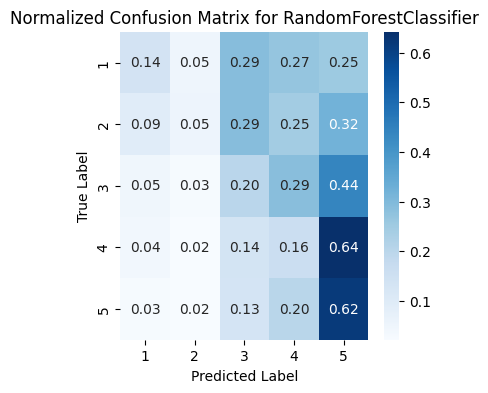

In [44]:
# Vectorization des avis lémmatisés
X_train = review_vector(train,['n_avis','sentiment_norm','longueur_texte'])
X_test = review_vector(test,['n_avis','sentiment_norm', "longueur_texte"])
# Train the Random Forest model
t0 = time.time()
model = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42)
model.fit(X_train, y_train)
model_report()

In [39]:
# Essai grid
# definir des hyper paramètres à tester
param_grid = {'n_estimators': [10, 50, 100, 200, 300],  
              'max_depth': [None, 10, 20, 30], 
              'min_samples_split': [2, 5, 10, 20, 30 ],
              'min_samples_leaf':[1, 2, 4]
              } 
# tester les différents paramètres
model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv = 5, n_jobs=-1, verbose = 3)
model.fit(X_train, y_train)
model_report()


Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.476 total time=   1.3s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.461 total time=   1.3s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.469 total time=   1.3s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.452 total time=   1.3s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.461 total time=   1.3s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.521 total time=   6.5s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.500 total time=   6.5s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.507 tot

KeyboardInterrupt: 

In [41]:
print("Best parameters:", model.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

# Best score on test is .66 with Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

In [ ]:
bench = pd.read_csv('../reports/model_benchmark.csv', index_col=0)
bench[bench.model == type(model).__name__]